Reproducing Fig. 3.2
Model specs: 
runs 10
agents 5
iterations 50
eta 0.5
fa 1

running iteration 1 of 50...
running iteration 2 of 50...
running iteration 3 of 50...
running iteration 4 of 50...
running iteration 5 of 50...
running iteration 6 of 50...
running iteration 7 of 50...
running iteration 8 of 50...
running iteration 9 of 50...
running iteration 10 of 50...
running iteration 11 of 50...
running iteration 12 of 50...
running iteration 13 of 50...
running iteration 14 of 50...
running iteration 15 of 50...
running iteration 16 of 50...
running iteration 17 of 50...
running iteration 18 of 50...
running iteration 19 of 50...
running iteration 20 of 50...
running iteration 21 of 50...
running iteration 22 of 50...
running iteration 23 of 50...
running iteration 24 of 50...
running iteration 25 of 50...
running iteration 26 of 50...
running iteration 27 of 50...
running iteration 28 of 50...
running iteration 29 of 50...
running iteration 30 of 50...
running iteration 31 of 50...

<IPython.core.display.Javascript object>


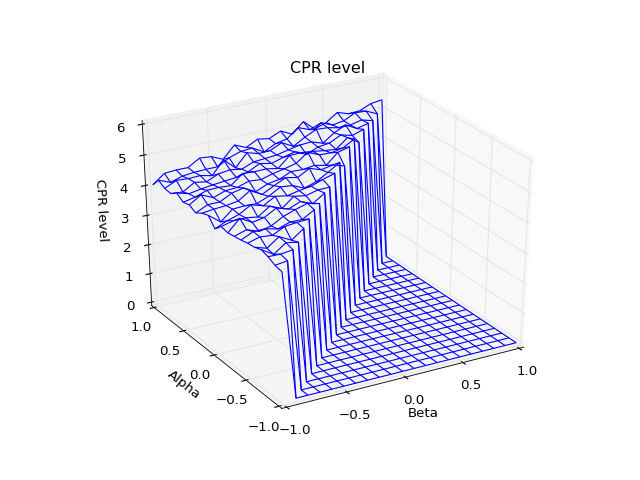

<IPython.core.display.Javascript object>


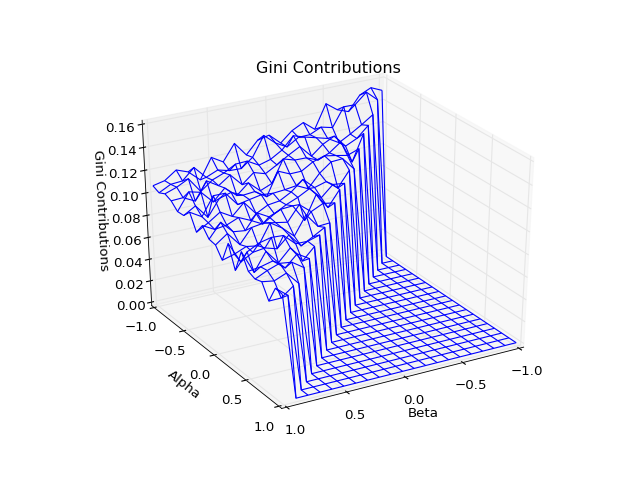

<IPython.core.display.Javascript object>


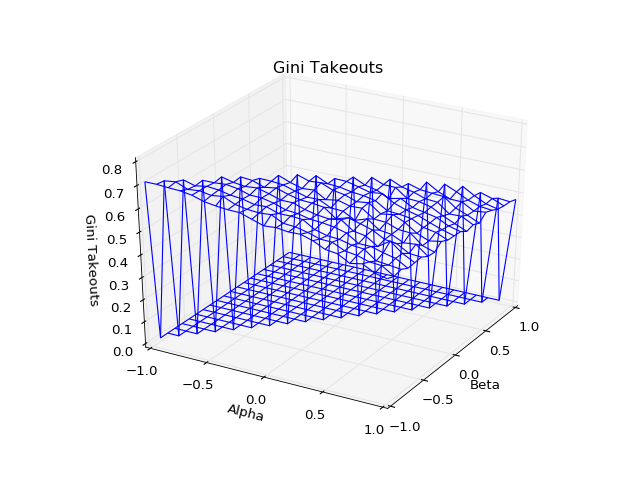

In [2]:
"""
Created on Sat Sep  3 12:38:36 2016
@author: Joe
"""

import random
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
from mesa import Model, Agent
from itertools import product
from mpl_toolkits.mplot3d import *


"""
Reproduction: Set the corresponding variable to "1" to reproduce results for
one of the figures in the Thesis. Please set all other of the variables to "0".
"""

figure3_2 = 1
figure3_3 = 0
figure3_5 = 0
figure3_6 = 0
figure3_7 = 0
figure3_8 = 0 #Note: Computationally intensive

if figure3_2 == 1:
    print("Reproducing Fig. 3.2")
elif figure3_3 == 1:
    print("Reproducing Fig. 3.3")
elif figure3_5 == 1:
    print("Reproducing Fig. 3.5")
elif figure3_6 == 1:
    print("Reproducing Fig. 3.6")
elif figure3_7 == 1:
    print("Reproducing Fig. 3.7")
elif figure3_8 == 1:
    print("Reproducing Fig. 3.8")
    
figurecheck = figure3_2 + figure3_3  + figure3_5  + figure3_6  + figure3_7 + figure3_8
if figurecheck > 1:
    sys.exit("Please select only one figure")
    
"""
Begin of Actual Model
"""

#Agent Class, generated by the Model class
class Resource_Agent(Agent):

#Initial Conditions
    def __init__(self, unique_id, alpha, beta, eta):
        self.unique_id = unique_id
        self.score = 0 #accumulating score
        self.subscore = 0 #score of this round only
        self.endowment = 1
        self.contribution = 0#(random.randrange(0, 11, 1)) / 10
        self.takeout_share = (random.randrange(0, 11, 1)) / 10
        self.alpha = alpha
        self.beta = beta
        self.eta = eta
        self.past_contributions = [self.contribution]
        self.past_takeout_shares = [self.takeout_share]
        self.total_contribution = 0
        self.total_amount_taken_out = 0

#Resource Provision Phase      
    def first_round(self, model):
        self.endowment = 1
        #self.subscore = 0
        self.contribution = ((np.random.choice(11, p = self.investment_p(model))) / 10)
        self.score += (self.endowment - self.contribution)
        self.subscore += (self.endowment - self.contribution)
        self.past_contributions.append(self.contribution)
        self.total_contribution += self.contribution
        model.sum_of_contributions += self.contribution
        
#Resource Allocation Phase
    def second_round(self, model):
        takeout_share = ((np.random.choice(11, p = self.extraction_p(model))) / 10)
        takeout = round(model.resource * takeout_share, 1)
        actual_takeout_share = round((takeout / (model.resource + 0.000000001)), 1)
        self.takeout_share = actual_takeout_share
        if takeout_share <= 0:
            takeout_share = 0
        self.past_takeout_shares.append(actual_takeout_share)
        self.score += takeout
        self.subscore += takeout
        model.resource -= takeout
        if model.resource < 0:
            model.resource = 0
        self.total_amount_taken_out += takeout
      
#Variant of the Allocation phase for the linear public good game. The resource
#provision phase is the same in both types of games.      
    def sym_second_round(self, model):
        takeout = model.equal_share
        self.takeout_share = 0.2
        self.past_takeout_shares.append(0.2)
        self.score += takeout
        self.subscore += takeout
        model.resource -= takeout
        if model.resource < 0:
            model.resource = 0
        self.total_amount_taken_out += takeout

        
#General functions, needed for the probabilistic choice calculations   
    def get_id(self):
        return self.unique_id        

    def determine_upstream_players(self, model):
        upstream_players = []
        for agent in model.schedule.agents:
            if agent.unique_id < self.get_id():
                upstream_players.append(agent)
        return upstream_players
    
    def determine_downstream_players(self, model):
        downstream_players = []
        for agent in model.schedule.agents:
            if agent.unique_id > self.get_id():
                downstream_players.append(agent)
        return downstream_players
        
    def last_round_sum_of_other_contributions(self, model):
        sum_of_contributions = 0
        for i in self.determine_upstream_players(model):
            sum_of_contributions += i.past_contributions[model.steps_this_round]
        for j in self.determine_downstream_players(model):
            sum_of_contributions += j.past_contributions[model.steps_this_round]
        return sum_of_contributions
    
    def last_round_upstream_agents_combined_takeout_shares(self, model):
        remaining_share = 1
        for i in self.determine_upstream_players(model):
            remaining_share = remaining_share * (1 - i.past_takeout_shares[model.steps_this_round])
        return remaining_share
    
    def this_round_upstream_players_combined_takeout_shares(self, model):
        remaining_share = 1
        for i in self.determine_upstream_players(model):
            remaining_share = remaining_share * (1 - i.takeout_share)
        return remaining_share

#Probabilistic Choice functions        
    def investment_p(self, model):
        xj = self.last_round_sum_of_other_contributions(model)
        yj = self.last_round_upstream_agents_combined_takeout_shares(model)
        u_list = []
        for x in range(0, 11, 1):
            wi = 1 - x/10 + yj * model.created_resource(x/10 + xj)
            wavg = 1 - 0.2 * x/10 - 0.2 * xj + 0.2 * model.created_resource(x/10 + xj)
            u_of_x = wi - self.alpha * max(wi - wavg, 0) + self.beta * max(wavg - wi, 0)
            u_list.append(u_of_x)
            p_list = []
            denominator = 0
            for u in u_list:
                denominator += math.exp(self.eta * u)
            for u in u_list:
                    numerator = math.exp(self.eta * u)
                    p_list.append(numerator / denominator)
        return p_list
        
    def extraction_p(self, model):
        x = self.contribution
        xij = 0
        for i in model.schedule.agents:
            xij += i.contribution
        yj = self.this_round_upstream_players_combined_takeout_shares(model)
        u_list = []
        for y in range(0, 11, 1):
            wi = 1 - x + y/10 * yj * model.created_resource(xij)
            wavg = 1 - 0.2 * xij + 0.2 * model.created_resource(xij)
            u_of_x = wi - self.alpha * max(wi - wavg, 0) + self.beta * max(wavg - wi, 0)
            u_list.append(u_of_x)
            p_list = []
            denominator = 0
            for u in u_list:
                denominator += math.exp(self.eta * u)
            if denominator == 0:
                for u in u_list:
                    p_list.append(1/11)
            else:
                for u in u_list:
                    numerator = math.exp(self.eta * u)
                    p_list.append(numerator / denominator)
        return p_list

#Model Class     
class Resource_Model(Model):
    
#Initial Conditions
    def __init__(self, N, alpha, beta, eta, fa, r, group_id = 1):
        self.num_agents = N
        self.alpha = alpha
        self.beta = beta
        self.eta = eta
        self.schedule = BaseScheduler(self)
        self.create_agents()
        self.resource = 0
        self.sum_of_contributions = 0
        # Variables needed for mesa's BatchRunner to work later
        self.total_produced_resource = 0
        self.running = True
        self.fa = fa # frequency of asymmetric games being played. Set to 1 for
        #only asymmetric games, and to 0 for only linear games being played.
        self.r = r #parameter in the resource generation function for the
        #linear games.
        self.equal_share = 0 #Determining the share each player receives in the
        #linear symmetric game.
        self.group_id = group_id
        self.this_round_produced_resource = 0
        self.steps_this_round = 0
        
    def create_agents(self):            
        for i in range(self.num_agents):
            a = Resource_Agent(i, self.alpha, self.beta, self.eta)
            self.schedule.add(a)
            
    def step(self, asym):
        #asym = np.random.choice(2, p = [self.fa, (1 - self.fa)])#Determines 
        #whether an asymmetric or linear game is being played.
        if asym == 0:
            self.schedule.step() #step function defined in mesa's BaseScheduler Class.
            #An asymmetric commons game is being played for this round.
        else:
            self.schedule.symstep() #Manually added function in mesa's BaseScheduler Class.
            #A linear public good game is being played in this round.
        self.total_produced_resource += self.created_resource(self.sum_of_contributions)
        self.this_round_produced_resource += self.created_resource(self.sum_of_contributions)
        self.sum_of_contributions = 0
        self.steps_this_round += 1
        
    def run_model(self, steps):
        asym = np.random.choice(2, p = [self.fa, (1 - self.fa)])
        self.this_round_produced_resource = 0
        self.steps_this_round = 0
        for a in self.schedule.agents:
            a.contribution = 0
            a.takeout_share = random.randrange(0, 11, 1) / 10
            a.past_contributions = [a.contribution]
            a.past_takeout_shares = [a.takeout_share]
            a.subscore = 0
        for i in range(steps):
            self.step(asym)

    def determine_generated_cpr(self): #Needed to collect CPR levels for runs with multiple iterations
        generated_cpr = self.total_produced_resource
        return generated_cpr

         
    def created_resource(self, sum_of_contributions): #resource function
        if sum_of_contributions >= 0 and sum_of_contributions < 1:
            produced_resource = 0
        elif sum_of_contributions >=1 and sum_of_contributions < 1.5:
            produced_resource = 0.5
        elif sum_of_contributions >=1.5 and sum_of_contributions < 2:
            produced_resource = 2
        elif sum_of_contributions >= 2 and sum_of_contributions < 2.5:
            produced_resource = 4
        elif sum_of_contributions >= 2.5 and sum_of_contributions < 3:
            produced_resource = 6
        elif sum_of_contributions >=3 and sum_of_contributions < 3.5:
            produced_resource = 7.5
        elif sum_of_contributions >=3.5 and sum_of_contributions < 4:
            produced_resource = 8.5
        elif sum_of_contributions >=4 and sum_of_contributions < 4.5:
            produced_resource = 9.5
        elif sum_of_contributions >=4.5 and sum_of_contributions <= 5:
            produced_resource = 10
        return produced_resource
      
#Needed to determine distribution of extractions between agent positions      
    def determine_agent_total_takeout(self):
        takeout_list = []
        for i in self.schedule.agents:
            takeout = i.total_amount_taken_out
            takeout_list.append(takeout)
        return takeout_list
        
#Needed to determine distribution of investments between agent positions        
    def determine_agent_total_contribution(self):
        contribution_list = []
        for i in self.schedule.agents:
            contribution = i.total_contribution
            contribution_list.append(contribution)
        return contribution_list


#BaseScheduler + BatchRunner: classes imported from mesa, modified as described
class BaseScheduler(object):
    model = None
    steps = 0
    time = 0
    agents = []

    def __init__(self, model):
        self.model = model
        self.steps = 0
        self.time = 0
        self.agents = []

    def add(self, agent):
        self.agents.append(agent)

    def remove(self, agent):
        while agent in self.agents:
            self.agents.remove(agent)

    def step(self):
    #Modified part. Adding a first (provision) and second(allocation) round
        for agent in self.agents:
            agent.first_round(self.model)
        self.model.resource = self.model.created_resource(self.model.sum_of_contributions)
        for agent in self.agents:            
            agent.second_round(self.model)
        self.steps += 1
        self.time += 1
     
    #Added function for the linear goods game 
    def symstep(self):
        for agent in self.agents:
            agent.first_round(self.model)
        self.model.resource = self.model.r * (self.model.sum_of_contributions)
        self.model.equal_share = (self.model.resource / 5)
        for agent in self.agents:            
            agent.sym_second_round(self.model)
        self.steps += 1
        self.time += 1


    def get_agent_count(self):
        return len(self.agents)

class BatchRunner(object):


    model_cls = None
    parameter_values = {}
    iterations = 1

    model_reporters = {}
    agent_reporters = {}

    model_vars = {}
    agent_vars = {}

    def __init__(self, model_cls, parameter_values, iterations=1,
                 max_steps=1000, model_reporters=None, agent_reporters=None):
        self.model_cls = model_cls
        self.parameter_values = {param: self.make_iterable(vals)
                                 for param, vals in parameter_values.items()}
        self.iterations = iterations
        self.max_steps = max_steps

        self.model_reporters = model_reporters
        self.agent_reporters = agent_reporters

        if self.model_reporters:
            self.model_vars = {}

        if self.agent_reporters:
            self.agent_vars = {}
            
    def run_all(self): # modified to give some progress info while the model is running
        params = self.parameter_values.keys()
        param_ranges = self.parameter_values.values()
        run_count = 0
        s = 1
        g = len(alpha_values) * len(beta_values)
        if figure3_6 == 1 or figure3_7 == 1:
            print("running...")
        elif figure3_8 ==1:
            pass
        else:
            print("running iteration " + str(s) + " of " + str(iterations) + "...")
        for param_values in list(product(*param_ranges)):
            kwargs = dict(zip(params, param_values))
            for _ in range(self.iterations):
                model = self.model_cls(**kwargs)
                self.run_model(model)
                # Collect and store results:
                if self.model_reporters:
                    key = tuple(list(param_values) + [run_count])
                    self.model_vars[key] = self.collect_model_vars(model)
                if self.agent_reporters:
                    for agent_id, reports in self.collect_agent_vars.items():
                        key = tuple(list(param_values) + [run_count, agent_id])
                        self.agent_vars[key] = reports
                run_count += 1
                if figure3_6 != 1 and figure3_7 != 1 and figure3_8 != 1:
                    if run_count % g == 0:
                        s += 1
                        if s <= iterations:
                            print("running iteration " + str(s) + " of " + str(iterations) + str("..."))
                        else:
                            print("")
                            print("Done!")
                         
    def run_model(self, model):
        while model.running and model.schedule.steps < self.max_steps:
            asym = np.random.choice(2, p = [model.fa, (1 - model.fa)])
            model.step(asym)
            
    def collect_model_vars(self, model):
        model_vars = {}
        for var, reporter in self.model_reporters.items():
            model_vars[var] = reporter(model)
        return model_vars
        
    def collect_agent_vars(self, model):
        agent_vars = {}
        for agent in model.schedule.agents:
            agent_record = {}
            for var, reporter in self.agent_reporters.items():
                agent_record[var] = reporter(agent)
            agent_vars[agent.unique_id] = agent_record
        return agent_vars
        
    def get_model_vars_dataframe(self):
        index_col_names = list(self.parameter_values.keys())
        index_col_names.append("Run")
        records = []
        for key, val in self.model_vars.items():
            record = dict(zip(index_col_names, key))
            for k, v in val.items():
                record[k] = v
            records.append(record)
        return pd.DataFrame(records)
        
    def get_agent_vars_dataframe(self):
        index_col_names = list(self.parameter_values.keys())
        index_col_names += ["Run", "AgentID"]
        records = []
        for key, val in self.agent_vars.items():
            record = dict(zip(index_col_names, key))
            for k, v in val.items():
                record[k] = v
            records.append(record)
        return pd.DataFrame(records)
        
    @staticmethod
    def make_iterable(val):
        if hasattr(val, "__iter__") and type(val) is not str:
            return val
        else:
            return [val]
                
    
#Functions for determining amounts of generated CPR, as well as ginis for investments and extractions,
# and distribution of investments and extractions between agent positions
def determine_final_resource(model):
    final_resource = model.determine_generated_cpr()
    return final_resource
    
def determine_takeouts(model):
    takeouts = model.determine_agent_total_takeout()
    return takeouts
    
def determine_contributions(model):
    contributions = model.determine_agent_total_contribution()
    return contributions

def compute_gini_takeouts(model):
    denominator = 0
    divisor = 0
    agent_takeout_sum = [agent.total_amount_taken_out for agent in model.schedule.agents]
    for xi in agent_takeout_sum:
        for xj in agent_takeout_sum:
            divisor += xj
            a = xi - xj
            if a < 0:
                a = -1 * a
            denominator += a
    gini = denominator / ((divisor * 2) + 0.000000000000000001)
    return gini
    
def compute_gini_contributions(model):
    denominator = 0
    divisor = 0
    agent_contribution_sum = [agent.total_contribution for agent in model.schedule.agents]
    for xi in agent_contribution_sum:
        for xj in agent_contribution_sum:
            divisor += xj
            a = xi - xj
            if a < 0:
                a = -1 * a
            denominator += a
    gini = denominator / ((divisor * 2) + 0.000000000000000001)
    return gini

#Function for running the cultural selection model    
def imitation_model(alpha, beta, eta, iterations, groups, m, epsilon, fa):
    group_list = []
    #creating groups of agents
    for j in range(groups):
        group_list.append(Resource_Model(agents, alpha, beta, eta, fa, r, j))
        
    #application of the white noise term
    its = 0
    rolling_output = []
    for g in range(iterations):
        its += 1
        rolling_avg_alpha = 0
        rolling_avg_beta = 0
        rolling_avg_cpr = 0
        for h in range(groups):
            group_list[h].run_model(runs)
            rolling_avg_cpr += group_list[h].this_round_produced_resource
            for j in group_list[h].schedule.agents:
                rolling_avg_alpha += (j.alpha / agents)
                rolling_avg_beta += (j.beta / agents)
        rolling_avg_cpr = (rolling_avg_cpr / (runs * groups))
        rolling_avg_beta = (rolling_avg_beta / groups)
        rolling_avg_alpha = (rolling_avg_alpha / groups)
        subroll = [its, rolling_avg_cpr, rolling_avg_alpha, rolling_avg_beta]
        rolling_output.append(subroll)
        
        for h in range(groups):
            for c in group_list[h].schedule.agents:
                noise = np.random.normal(0, 0.01)
                c.alpha += noise
                #ensuring alpha <= 1
                if c.alpha > 1:
                    c.alpha = 1
                if c.alpha <-1:
                    c.alpha = -1
                noise = np.random.normal(0, 0.01)
                c.beta += noise
                #ensuring beta <= alpha
                if c.beta > c.alpha:
                    c.beta = c.alpha
                if c.beta < -1:
                    c.beta = -1
        
        #Copying traits of another agent from same(p=1-m) or another group(p=m)
        #after each set of rounds, with specified probability depending on agents'
        #past payoff
        for h in range(groups):
            for x in group_list[h].schedule.agents:
                #Determining if agent from the same group or another is faced 
                agent_imitation = np.random.choice(2, p = [(1-m), m])
                w_i = x.score
                jchoice = np.random.choice(agents)
                #Facing random agent from the same group
                if agent_imitation == 0:
                    j = group_list[h].schedule.agents[jchoice]
                    w_j = j.score
                    #probability of imitation
                    imit_p = (w_j / (w_i + w_j + 0.0000000000000001))
                    imit = np.random.choice(2, p = [imit_p, (1 - imit_p)])
                    if imit == 0:
                        x.alpha = j.alpha
                        x.beta = j.beta
                #facing an agent from another group
                else:           
                    gchoice = np.random.choice(groups)
                    j = group_list[gchoice].schedule.agents[jchoice]
                    w_j = j.score
                    #probability of imitation
                    imit_p = (w_j / (w_i + w_j + 0.00000000000000001))
                    imit = np.random.choice(2, p = [imit_p, (1 - imit_p)])
                    if imit == 0:
                        x.alpha = j.alpha
                        x.beta = j.beta
                            
        #Intergroup interaction
        average_fitness = 0
        for h in range(groups):
            average_fitness += group_list[h].total_produced_resource
        average_fitness = (average_fitness/groups)
        
        for h in range(groups):
            #determining if intergroup interaction takes place
            group_imitation = np.random.choice(2, p=[epsilon, (1 - epsilon)])
            #if intergroup interaction takes place:
            if group_imitation == 0: 
                #Determining W_i
                fitness_i = (group_list[h].total_produced_resource / (average_fitness + 0.000000000001))
                s_i = 0 #Determining s_i
                for a in group_list[h].schedule.agents:
                    if a.subscore >= 10:
                        s_i +=1
                s_i = (s_i / agents)
                gchoice = np.random.choice(groups) #Choosing another group at random
                #Determining W_j
                fitness_j = (group_list[gchoice].total_produced_resource / (average_fitness + 0.0000000000000001))
                s_j = 0 #Determining s_j
                for b in group_list[gchoice].schedule.agents:
                    if b.subscore >= 10:
                        s_j += 1
                s_j = (s_j / agents)
                imit_p = ((1 + ((fitness_j * s_j) - (fitness_i * s_i))) / 2)
                if imit_p < 0:
                    imit_p = 0
                elif imit_p > 1:
                    imit_p = 1
                #Determining which group copies traits from the other group 
                imit = np.random.choice(2, p = [imit_p, (1 - imit_p)])
                #group i imitating group j
                if imit == 0:
                    z = 0
                    for x in group_list[h].schedule.agents:
                        j = group_list[gchoice].schedule.agents[z]
                        x.alpha = j.alpha
                        x.beta = j.beta
                        z += 1
                #group j imitating group i
                else:
                    z = 0
                    for x in group_list[gchoice].schedule.agents:
                        j = group_list[h].schedule.agents[z]
                        x.alpha = j.alpha
                        x.beta = j.beta
                        z += 1
    return rolling_output
    
    


#Model Parameter settings.
runs = 10 #corresponding to c
agents = 5
#alpha = 1 #Used for the run with variable eta
#beta = 1 #Used for the run with variable eta
#eta = 15
#fa = 0 #frequency of asymmetric games played.
r = 2 #parameter in the linear resource generating function.
iterations = 10 #iterations for each parameter combination
eta_values = [0, 0.125, 0.25, 0.375, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8, 12, 15, 16, 32]
#Used for the run with variable eta
alpha_values = [] #the range of values for alpha with which the iterated model is run
for i in range(-10, 11):
    x = i/10
    alpha_values.append(x)
beta_values = [] #the range of values for beta with which the iterated model is run
for i in range(-10, 11):
    x = i/10
    beta_values.append(x)
#visualization settings
visu3d = 0

if figure3_2 == 1:
    visu3d = 1
    runs = 10
    agents = 5
    eta = 0.5
    fa = 1
    iterations = 50
    #parameters for the BatchRunner, i.e. the iterated model
    param_values = {"N": agents, "alpha": alpha_values, "beta": beta_values, "eta": eta,
                "fa": fa, "r": r}
    model_reporter = {"Generated_CPR": determine_final_resource,
                  "Gini_Contributions": compute_gini_contributions, 
                  "Gini_Takeouts": compute_gini_takeouts}
    batch = BatchRunner(Resource_Model, param_values, iterations, runs, model_reporter)
    
if figure3_3 == 1:
    visu3d = 1
    runs = 10
    agents = 5
    eta = 0.5
    fa = 0
    iterations = 50
    #parameters for the BatchRunner, i.e. the iterated model
    param_values = {"N": agents, "alpha": alpha_values, "beta": beta_values, "eta": eta,
                "fa": fa, "r": r}
    model_reporter = {"Generated_CPR": determine_final_resource,
                  "Gini_Contributions": compute_gini_contributions, 
                  "Gini_Takeouts": compute_gini_takeouts}
    batch = BatchRunner(Resource_Model, param_values, iterations, runs, model_reporter)
    

if figure3_5 == 1:
    visu3d = 1
    runs = 10
    agents = 5
    eta = 15
    fa = 1
    iterations = 50
    #parameters for the BatchRunner, i.e. the iterated model
    param_values = {"N": agents, "alpha": alpha_values, "beta": beta_values, "eta": eta,
                "fa": fa, "r": r}
    model_reporter = {"Generated_CPR": determine_final_resource,
                  "Gini_Contributions": compute_gini_contributions, 
                  "Gini_Takeouts": compute_gini_takeouts}
    batch = BatchRunner(Resource_Model, param_values, iterations, runs, model_reporter)
    
if figure3_6 == 1:
    runs = 10
    agents = 5
    fa = 1
    iterations = 500
    #parameters for the BatchRunner, i.e. the iterated model
    param_values = {"N": agents, "alpha": -1, "beta": -1, "eta": eta_values,
                "fa": fa, "r": r}
    model_reporter = {"Generated_CPR": determine_final_resource,
                  "Gini_Contributions": compute_gini_contributions, 
                  "Gini_Takeouts": compute_gini_takeouts}
    batch = BatchRunner(Resource_Model, param_values, iterations, runs, model_reporter)
    batch.run_all()
    out = batch.get_model_vars_dataframe() # Stores the collected data
    grouped = out.groupby("eta").mean()
    y = grouped.Generated_CPR
    ylist = np.array(y)
    ylist = ylist / 10
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel("eta")
    ax1.set_ylabel("CPR level")
    ax1.set_title("alpha = -1, beta = -1")
    ax1.plot(eta_values, ylist)
    ax1.axvline(15, color = "red")
    ax1.axhline(0.075, color = "green")
    ax1.set_xscale('log', basex = 2)
    fig.show()
    
    
    param_values2 = {"N": agents, "alpha": 1, "beta": -0.2, "eta": eta_values,
                "fa": fa, "r": r}
    batch2 = BatchRunner(Resource_Model, param_values2, iterations, runs, model_reporter)
    batch2.run_all()
    out2 = batch2.get_model_vars_dataframe() # Stores the collected data
    grouped2 = out2.groupby("eta").mean()
    y2 = grouped2.Generated_CPR
    ylist2 = np.array(y2)
    ylist2 = ylist2 / 10
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel("eta")
    ax2.set_ylabel("CPR level")
    ax2.set_title("alpha = 1, beta = -0.2")
    ax2.plot(eta_values, ylist2)
    ax2.axvline(15, color = "red")
    ax2.axhline(2, color = "green")
    ax2.set_xscale('log', basex = 2)
    fig2.show()

    param_values3 = {"N": agents, "alpha": 1, "beta": 1, "eta": eta_values,
                "fa": fa, "r": r}
    batch3 = BatchRunner(Resource_Model, param_values3, iterations, runs, model_reporter)
    batch3.run_all()
    out3 = batch3.get_model_vars_dataframe() # Stores the collected data    
    grouped3 = out3.groupby("eta").mean()
    y3 = grouped3.Generated_CPR
    ylist3 = np.array(y3)
    ylist3 = ylist3 / 10
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    ax3.set_xlabel("eta")
    ax3.set_ylabel("CPR level")
    ax3.set_title("alpha = 1, beta = 1")
    ax3.plot(eta_values, ylist3)
    ax3.axvline(15, color = "red")
    ax3.axhline(7, color = "green")
    ax3.set_xscale('log', basex = 2)
    fig3.show()

if figure3_7 == 1:
    runs = 10
    agents = 5
    eta = 15
    fa = 1
    iterations = 5000
    model_reporter = {"Takeouts": determine_takeouts, "Contributions": determine_contributions}
    scale = iterations * runs
    ind = np.arange(agents)
    width = 0.28

    param_values = {"N": agents, "alpha": 0.85, "beta": 0.4, "eta": eta,
                "fa": fa, "r": r}
    batch = BatchRunner(Resource_Model, param_values, iterations, runs, model_reporter)
    batch.run_all()
    out = batch.get_model_vars_dataframe()
    contrib = out.Contributions[0]
    for j in range(1, iterations):
        subcon = out.Contributions[j]
        contrib = [contrib[i]+subcon[i] for i in range(len(contrib))]
    contrib = [(contrib[i]/scale) for i in range(len(contrib))]
    extrac = out.Takeouts[0]
    for j in range(1, iterations):
        subex = out.Takeouts[j]
        extrac = [extrac[i]+subex[i] for i in range(len(extrac))]
    extrac = [(extrac[i]/scale) for i in range(len(extrac))]    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind + width, contrib, width, color = "blue")
    rects2 = ax.bar(ind + width * 2, extrac, width, color = "red")
    ax.set_xlim(-width, len(ind) + width)
    ax.set_ylabel("Contributions/Extractions")
    ax.set_title("Alpha: " + str(0.85) + " Beta: " + str(0.4))
    xTickMarks = ["Agent" + str(i) for i in range(agents)]
    ax.set_xticks(ind + width)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation = 45, fontsize = 10)    
    ax.legend((rects1[0], rects2[0]), ("Contributions", "Extractions"))
    fig.show()
    
    param_values2 = {"N": agents, "alpha": 1, "beta": 0.75, "eta": eta,
                "fa": fa, "r": r}
    batch2 = BatchRunner(Resource_Model, param_values2, iterations, runs, model_reporter)
    batch2.run_all()
    out2 = batch2.get_model_vars_dataframe()
    contrib2 = out2.Contributions[0]
    for j in range(1, iterations):
        subcon2 = out2.Contributions[j]
        contrib2 = [contrib2[i]+subcon2[i] for i in range(len(contrib2))]
    contrib2 = [(contrib2[i]/scale) for i in range(len(contrib2))]
    extrac2 = out.Takeouts[0]
    for j in range(1, iterations):
        subex2 = out2.Takeouts[j]
        extrac2 = [extrac2[i]+subex2[i] for i in range(len(extrac2))]
    extrac2 = [(extrac2[i]/scale) for i in range(len(extrac))]    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    rects3 = ax2.bar(ind + width, contrib2, width, color = "blue")
    rects4 = ax2.bar(ind + width * 2, extrac2, width, color = "red")
    ax2.set_xlim(-width, len(ind) + width)
    ax2.set_ylabel("Contributions/Extractions")
    ax2.set_title("Alpha: " + str(1) + " Beta: " + str(0.75))
    xTickMarks = ["Agent" + str(i) for i in range(agents)]
    ax2.set_xticks(ind + width)
    xtickNames = ax2.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation = 45, fontsize = 10)    
    ax2.legend((rects3[0], rects4[0]), ("Contributions", "Extractions"))
    fig2.show()

    param_values3 = {"N": agents, "alpha": 1, "beta": 1, "eta": eta,
                "fa": fa, "r": r}
    batch3 = BatchRunner(Resource_Model, param_values3, iterations, runs, model_reporter)
    batch3.run_all()
    out3 = batch3.get_model_vars_dataframe()
    contrib3 = out3.Contributions[0]
    for j in range(1, iterations):
        subcon3 = out3.Contributions[j]
        contrib3 = [contrib3[i]+subcon3[i] for i in range(len(contrib3))]
    contrib3 = [(contrib3[i]/scale) for i in range(len(contrib3))]
    extrac3 = out.Takeouts[0]
    for j in range(1, iterations):
        subex3 = out3.Takeouts[j]
        extrac3 = [extrac3[i]+subex3[i] for i in range(len(extrac3))]
    extrac3 = [(extrac3[i]/scale) for i in range(len(extrac))]    
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    rects5 = ax3.bar(ind + width, contrib3, width, color = "blue")
    rects6 = ax3.bar(ind + width * 2, extrac3, width, color = "red")
    ax3.set_xlim(-width, len(ind) + width)
    ax3.set_ylabel("Contributions/Extractions")
    ax3.set_title("Alpha: " + str(1) + " Beta: " + str(1))
    xTickMarks = ["Agent" + str(i) for i in range(agents)]
    ax3.set_xticks(ind + width)
    xtickNames = ax3.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation = 45, fontsize = 10)    
    ax3.legend((rects5[0], rects6[0]), ("Contributions", "Extractions"))
    fig3.show()
    
if figure3_8 == 1:
    runs = 10
    agents = 5
    eta = 15
    iterations = 3000
    groups = 100
    m = 0.001 #Probability of facing an agent from another group vs. from the
    #agent's own group
    epsilon = 0.015 #Probability of intergroup interaction
    subiterations = 1
    fa_range = 11 #Specifying the range of the frequency of asymmetric games,
    #fa
    out = []
    run_id = 1 #Gives the output file a unique id in order to avoid overwriting
    print("run_id: " + str(run_id))
    #print("running...")
    for j in range(0, fa_range):
        print("Running fa = " + str(j/10) + "...")
        results = [0, 0, 0, 0]
        for g in range(subiterations):#Collecting Averages of multiple
        #iterations for subiterations > 1
            alpha = 0 # starting value for alpha
            beta = 0 # starting value for beta
            #print("Running iteration " + str(g + 1) + " of " + str(subiterations) + "...")
            sublist = imitation_model(alpha, beta, eta, iterations, groups, m, epsilon, j/10)
            #Referring to the imitation_model function defined above
            results = [results[i]+sublist[(iterations - 1)][i] for i in range(len(results))]
            out2 = pd.DataFrame(sublist)
            
            plt.plot(out2[1])
            plt.xlabel("Round")
            plt.ylabel("Average CPR value")
            plt.title("Development of CPR, fa = " + str(j/10))
            plt.show()
            
            alpha = plt.plot(out2[2], label = "alpha")#, marker = "d")
            beta = plt.plot(out2[3], label = "beta")#, marker = "s")
            plt.legend()
            plt.xlabel("Rounds")
            plt.ylabel("Average values for alpha and beta")
            plt.title("Development of alpha and beta, fa = " + str(j/10))
            plt.ylim(-1, 1)
            plt.hlines(0, 0, iterations)
            plt.show()

        results = (np.array(results))
        results = (results/subiterations)
        out.append(results)
        
    #Visualization

    out = pd.DataFrame(out)

    
    #Visualization
    plt.plot(out[1])
    plt.xlabel("Number of times an asymmetric game is played")
    plt.ylabel("Average CPR value")
    plt.xticks(range(11))
    plt.show()
    
    alpha = plt.plot(out[2], label = "alpha", marker = "d")
    beta = plt.plot(out[3], label = "beta", marker = "s")
    plt.legend()
    plt.xticks(range(11))
    plt.xlabel("Number of times an asymmetric game is played")
    plt.ylabel("Average values for alpha and beta")
    plt.ylim(-1, 1)
    plt.hlines(0, 0, 10)
    plt.show()
    
    filename = str("SelectionModel_ID" + str(run_id) + ".csv")
    out.to_csv(str(filename))
    print("Output saved as " + str(filename))

    


    
#Printout of information on the running model
print("Model specs: ")
print("runs " + str(runs))
print("agents " + str(agents))
print ("iterations " + str(iterations))
if figure3_6 != 1:
    print("eta " + str(eta))
if figure3_8 != 1:
    print("fa " + str(fa))
print("")

if figure3_6 != 1 and figure3_7 != 1 and figure3_8 != 1:
    batch.run_all()
    out = batch.get_model_vars_dataframe() # Stores the collected data

#Saving the output as an analyzable .csv file
if figure3_6 != 1 and figure3_7 != 1 and figure3_8 != 1:
    filename = str(runs) + "runs_" + str(agents) + "agents_" + str(iterations) + "iterations_" + str(eta) + "eta_" + str(fa) + "fa.csv"
    out.to_csv(str(filename))
    print("Output saved as " + str(filename))
"""elif figure3_8 == 1:
    filename = str("results_" + str(eta) + "eta_" + str(iterations) + "iterations.csv")
    out.to_csv(str(filename))
    print("Output saved as " + str(filename))"""
    

#3D-Visualization
if visu3d == 1:
    out_one = out[out.alpha >= out.beta]
    out_two = out[out.beta > out.alpha]
    for j in out_two.index:
        out_two.set_value(j, "Generated_CPR", 0)
        out_two.set_value(j, "Gini_Contributions", 0)
        out_two.set_value(j, "Gini_Takeouts", 0)
    out = out_one.merge(out_two, how="outer")
    grouped_all = out.groupby(["alpha", "beta"]).mean()
    resource_values = grouped_all.Generated_CPR
    resource_list = np.array(resource_values)
    resource_list = ((resource_list) / runs)
    z_values = [resource_list[x:x+21] for x in range(0, len(resource_list), 21)]
    variables = []
    for j in range(-10, 11):
        variables.append(j/10)
        x = []
    for j in range(21):
        x.append(variables)      
    y = []
    for j in variables:
        sublist = []
        for s in range(21):
            sublist.append(j)
        y.append(sublist)
    data = (x, y, z_values)
    X, Y, Z = data
    contri_gini_values = grouped_all.Gini_Contributions
    contri_gini_list = np.array(contri_gini_values)
    a_values = [contri_gini_list[x:x+21] for x in range(0, len(contri_gini_list), 21)]
    data2 = (x, y, a_values)
    X, Y, A = data2
    takeout_gini_values = grouped_all.Gini_Takeouts
    takeout_gini_list = np.array(takeout_gini_values)
    b_values = [takeout_gini_list[x:x+21] for x in range(0, len(takeout_gini_list), 21)]
    data3 = (x, y, b_values)
    X, Y, B = data3
    def plot_3d(X, Y, Z, zaxis_label, azim, elev, invert_xaxis=True, invert_yaxis=True):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        X = np.array(X)
        Y = np.array(Y)
        Z = np.array(Z)
        if invert_xaxis==True:
            plt.gca().invert_xaxis()
        if invert_yaxis==True:
            plt.gca().invert_yaxis()
        ax.plot_wireframe(X, Y, Z)
        ax.set_xlabel('Beta')
        ax.set_ylabel('Alpha')
        ax.set_zlabel(str(zaxis_label))
        ax.set_title(str(zaxis_label))
        ax.view_init(azim, elev)
        plt.show()
    
    plot_3d(X, Y, Z, "CPR level", 30, 60)
    plot_3d(Y, X, A, "Gini Contributions", 30, 60, invert_xaxis=False, invert_yaxis=False)
    plot_3d(X, Y, B, "Gini Takeouts", 30, 30, invert_xaxis=True, invert_yaxis=False)